# Task 2 & 3

## Solution description

The aim of this challenge is to create the best forecasting model. Thus, instead of pursuing classical time series analysis based on statistical analysis, data-driven approach will be pursued. Time series will be split into train, validation and test set:
* Train will consist of observations in years 1994-2017
* Validation will consist of observations in years 2018-2019
* Test will consist of observations in year 2020

Multiple time series models will be trained and their predictive power will be predicted using the [rolling window](https://www.quora.com/What-does-the-term-rolling-window-mean-in-econometrics) strategy. Due to time constraint in most cases hyperparameters of the models are not optimized. Based on the results of the model performance on the validation set the best models will be chosen. These will be naively ensembled i.e. weighted mean with fixed parameters of their predictions will be caluclated and evaluated on the test set. Hopefully, this trick will yield the boost of metrics on the test set. Due to relatively small values of the time series, the main metric to be optimized is MAE. However, additional metrics are also calculated. Full list can be found below.

## Solution advantages

The above approach allows to pick the best model and assess its performance. Thus, the stability of predicitons is ensured. Moreover, optimization of metric yields better due to the nature of optimization. Thus, the quality of predictions is ensured.

## Solution disadvantages

Application of pure machine learning approach could be risky if the data is not thorougly examined and explained based on the nature of the observed phenomenon. Otherwise risk of being deluded by spurious correlations can be significant. Hopefully, the time series analysis performed in the Task 1 provides sufficient proof regarding the structural properties of the time series and protects against falling into this trap.

## Solution shortcomings

Due to the time constraint not everything was achieved in this analysis. In particular:

* Not all hyperparameters of models were optimized
* All the transformations of the time series were not used for every model
* No external data was added to boost prediction performance

Any of the above could significantly boost the performance of the final model and could be perceived as potential directions of furter improvements.

## Packages and data loading

In [2]:
! pip install fbprophet --quiet
! pip install statsmodels==0.12.1 --quiet
! pip install neuralprophet --quiet
! pip install nbeats-forecast --quiet
! pip install tbats --quiet

In [3]:
from google.colab import files
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from fbprophet import Prophet
from neuralprophet import NeuralProphet
from tbats import TBATS, BATS
from nbeats_forecast import NBeats
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy import stats
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt.pyll.base import scope
from scipy.special import boxcox, inv_boxcox

import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger("fbprophet")
logger.propagate = False

logger = logging.getLogger("neuralprophet")
logger.propagate = False

In [4]:
uploaded = files.upload()

Saving Lions_Den_data.xlsx to Lions_Den_data.xlsx


Setting parameters

In [5]:
DATA_PATH = 'Lions_Den_data.xlsx'
DATE_COLUMN = 'DATE'

HOR = 12 #horizon
TEST_PREDICTIONS_TITLE = f'test predictions horizon: {HOR} months'
VAL_PREDICTIONS_TITLE = f'exampled val predictions horizon: {HOR} months'
DECOMPOSED_TITLE = f'added predictions on decomposed series horizon: {HOR} months'

TRAIN_LEN = 282
VAL_LEN = 24

In [6]:
df = pd.read_excel(DATA_PATH, index_col=0, parse_dates=True)

## Data transformations:

Seasonal decomposition (additive trend, period equal to 12) and Box-Cox transformation (with the best lambda param found on train) will be used. In order to override <b>nan</b> values at the beginning of the trend series we will replace them (5 values) with the first existing value. As Box-Cox transformations require <b>positive</b> values small number (0.00001) is added. All transformations yield 5 time series: 
1. original
2. original transformed with Box-Cox, 
3. time series decomposition i.e.:
  * trend component
  * season component
  * residual component

In [7]:
eps = 0.00001

res = seasonal_decompose(df, model="additive", period=12)

_, param = stats.boxcox(np.squeeze(df.iloc[:TRAIN_LEN].values + eps))
df['org_box_cox'] = stats.boxcox(np.squeeze(df.values + eps), param)

print('Optimal lambda', param)
inv_boxcox(df['org_box_cox'], param)

df_seasonal = pd.DataFrame({'season': res.seasonal, 'trend':res.trend, 'resid': res.resid})
df_seasonal['org'] = df[df.columns[0]]
df_seasonal['org_box_cox'] = df['org_box_cox']

df = df_seasonal.copy()
df = df.fillna(df.loc[~df['trend'].isnull()].iloc[0])

Optimal lambda 0.2354151839962227


In [8]:
df.head()

,season,trend,resid,org,org_box_cox
DATE,,,,,
1994-07-01,-0.096423,0.272875,0.115366,0.076,-1.931991
1994-08-01,-0.097570,0.272875,0.115366,0.097,-1.795101
1994-09-01,-0.087363,0.272875,0.115366,0.140,-1.573833
1994-10-01,-0.064095,0.272875,0.115366,0.213,-1.296193
1994-11-01,-0.011133,0.272875,0.115366,0.345,-0.941348


In [9]:
columns = df_seasonal.columns

Text(0.5, 1.0, 'Original series with Box-Cox transformation')

<Figure size 432x288 with 0 Axes>

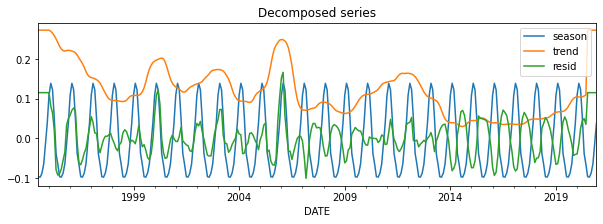

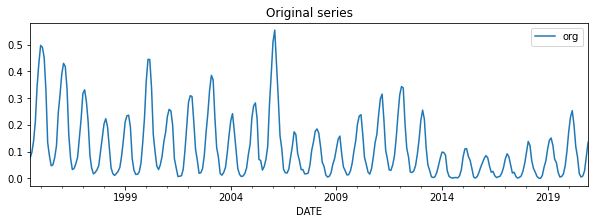

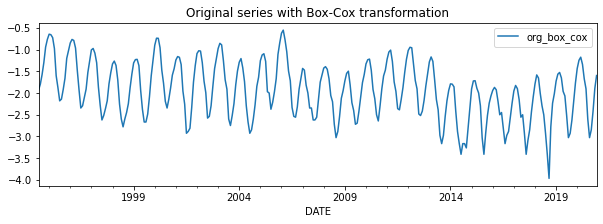

In [10]:
plt.figure(); df[df.columns[:-2]].plot(figsize=(10,3)); plt.legend(loc='best'); plt.title('Decomposed series')
plt.figure(); df[df.columns[-2]].plot(figsize=(10,3)); plt.legend(loc='best'); plt.title('Original series')
plt.figure(); df[df.columns[-1]].plot(figsize=(10,3)); plt.legend(loc='best'); plt.title('Original series with Box-Cox transformation')

## Models

The following models were used in this analysis:

1. parametric models: SAR(I)MA

2. nonparametric models: ETS, TBATS

3. bayesian models: Prophet, Neural Prophet

4. deep learning models: N-beats


The following metrics are calculated: mae 	mse 	r2 	mape 	smape

1. MAE
2. RMSE
3. MAPE
4. SMAPE
5. $R^2$

## Helper functions (non-technical users can skip this part)

In [11]:
def plot_prediction(train, val, preds, title='', future=False):
    prediction = pd.DataFrame()
    prediction['real'] = np.concatenate((train, val))
    prediction['yhat'] = np.concatenate((train, np.squeeze(preds)), axis=0)

    if future:
        prediction = pd.DataFrame()
        prediction['real'] = train
        prediction['yhat'] = train


    plt.figure(figsize=(10,3)) 
    plt.plot(range(prediction.shape[0]), prediction['real'].values, label='real')
    plt.plot(range(train.shape[0] ,preds.shape[0] + train.shape[0]), preds, label='forecast')
    plt.legend(loc='best')
    plt.title(title)

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 0.01))) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (0.01 + np.abs(y_true) + np.abs(y_pred)))

def evaluate(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    scores = {}
    scores['mae'] = mean_absolute_error(y_true, y_pred)
    scores['mse'] = mean_squared_error(y_true, y_pred)
    scores['r2'] = r2_score(y_true, y_pred)
    scores['mape'] = mape(y_true, y_pred)
    scores['smape'] = smape(y_true, y_pred)
    return scores

## Model training functions (non-technical users can skip this part)

In [12]:
def prophet(train, val, col='org'):
  train_data = pd.DataFrame()
  train_data['y'] = train[col].copy()
  train_data['ds'] = train_data.index
  train_data.columns = ['y', 'ds']

  val_data = pd.DataFrame()
  val_data['y'] = val[col].copy()
  val_data['ds'] = val_data.index
  val_data.columns = ['y', 'ds']

  m = Prophet()
  m.fit(train_data)
  future = m.make_future_dataframe(periods=val_data.shape[0], freq='M')
  forecast = m.predict(future).tail(val_data.shape[0])['yhat'].values
  return  (evaluate(val_data['y'].values, forecast), forecast)


def neural_prophet(train, val, col='org'):
  train_data = pd.DataFrame()
  train_data['y'] = train[col].copy()

  train_data['ds'] = train_data.index
  train_data.columns = ['y', 'ds']

  val_data = pd.DataFrame()
  val_data['y'] = val[col].copy()
  val_data['ds'] = val_data.index
  val_data.columns = ['y', 'ds']

  m = NeuralProphet()
  m.fit(train_data, freq='M')
  future = m.make_future_dataframe(train_data, periods=val_data.shape[0])
  forecast = m.predict(future)['yhat1'].values
  return  (evaluate(val_data['y'].values, forecast), forecast)


def nbeats(train, val, col='org'):
  train_data = np.expand_dims(train[col].values, axis=1)
  val_data =  np.expand_dims(val[col].values, axis=1)

  backcast_length = 150

  model = NBeats(data=train_data, period_to_forecast=HOR, backcast_length=backcast_length)
  model.fit(epoch=2)
  forecast = model.predict()
  return  (evaluate(val_data, forecast), forecast)


def tbats(train, val, col='org'):
  train_data = train[col].copy()
  val_data = val[col].copy()

  estimator = TBATS(seasonal_periods=[12, 5])

  fitted_model = estimator.fit(train_data.values)

  forecast = fitted_model.forecast(steps=HOR)
  return  (evaluate(val_data, forecast), forecast)


def sarima(train, val, col='org', future=False, p=2, d=1, q=2, trend='c',  P=0, D=0, Q=0, s=12, use_boxcox=True):
  train_data = train[col].copy()
  val_data = val[col].copy()
  mod = sm.tsa.statespace.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s), use_boxcox=use_boxcox, initialization_method="estimated")
  res = mod.fit()

  forecast = res.forecast(steps=HOR)
  if not future:
      return  (evaluate(val_data, forecast), forecast)
  else:
      return  (evaluate(forecast, forecast), forecast)


def ets(train, val, col='org', trend='mul', seasonal='mul', use_boxcox=False):
  epsilon = 2
  train_data = train[col].copy() + epsilon
  val_data = val[col].copy() + epsilon

  mod = ExponentialSmoothing(train_data, seasonal_periods=12, trend=trend, seasonal=seasonal, use_boxcox=use_boxcox, initialization_method="estimated")
  res = mod.fit()

  forecast = res.forecast(steps=HOR) - epsilon
  return  (evaluate(val_data, forecast), forecast)

## Rolling window functions (non-technical users can skip this part)

In [13]:
def rolling_window(model_name, col, params={}):
  data = pd.concat([df_train, df_val])
  scores = []
  forecasts = []
  results[model_name] = {}

  for i in range(df_train.shape[0], df_train.shape[0] + df_val.shape[0] - HOR):
    train = data.iloc[:i]
    val = data.iloc[i : i + HOR]
    s, f = train_functions[model_name](train, val, col=col, **params)
    scores.append(s)
    forecasts.append((f, val))

  results[model_name][col] = results.get(col, {})
  results[model_name][col] = pd.DataFrame(scores).sum(axis=0).to_dict()

  forecasts_dec_val[model_name][col] = forecasts_dec_val.get(col, [])
  forecasts_dec_val[model_name][col] = forecasts

In [14]:
df_train = df.iloc[:TRAIN_LEN]
df_val  = df.iloc[TRAIN_LEN: TRAIN_LEN + VAL_LEN]
df_test  = df.iloc[TRAIN_LEN + VAL_LEN:]

print(df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0])

True


In [15]:
results = {}
results_test = {}
forecasts_test = {}
forecasts_val = {}
forecasts_dec_val = {}

In [16]:
train_functions = {'prophet': prophet,
                   'neural prophet': neural_prophet,
                   'NBeats': nbeats,
                   'TBATS': tbats,
                   'SARIMA': sarima,
                   'ETS': ets}

## Evaluation of models

Below you will find the evaluation of each of selected time series forecasting techniques. Each model has short description and visualization of preditions on validation and test set.

## Prophet

Additive model that supports trends (modeled by piecewise linear or logistic growth curve), seasonality (modeled using Fourier series or with dummy variables), and holidays. Is set to be reboust to missing data and shifts in the trend, and typically handles outliers well. This open-source tool was developped by Facebook. 

It has very simple api and can be used as benchmark especialy that it handles well seasonal data.

In [17]:
model_name = 'prophet'
col = 'org_box_cox'
function = train_functions[model_name]
results_test[model_name] = {}
forecasts_test[model_name] = {}
forecasts_val[model_name] = {}
forecasts_dec_val[model_name] = {}

rolling_window(model_name, col)

_, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, HOR // 12 + 1)]
forceast_val = np.concatenate(forceast_val)

forecasts_val[model_name][col] = forecasts_val.get(col, {})
forecasts_val[model_name][col] = forceast_val

results_test[model_name][col] = results_test.get(col, {})
results_test[model_name][col] = evaluate(df_test[col], forecast_test)

forecasts_test[model_name][col] = forecasts_test.get(col, {})
forecasts_test[model_name][col] = forecast_test

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


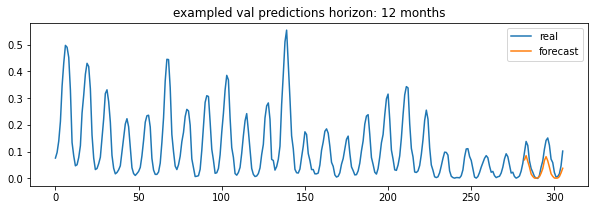

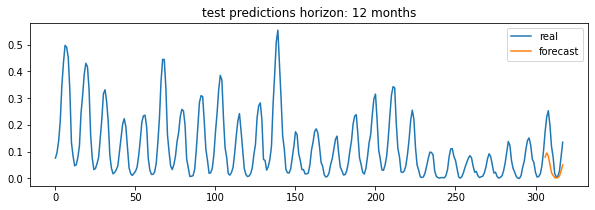

In [34]:
plot_prediction(df_train['org'].values, df_val['org'].values, inv_boxcox(forceast_val, param), title=VAL_PREDICTIONS_TITLE)
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, inv_boxcox(forecasts_test[model_name]['org_box_cox'], param), title=TEST_PREDICTIONS_TITLE)

<h2> Neural Prophet </h2>

Neural network modeled based on Prophet. It is decomposable time series model with the components, trend, seasonality (modelled using Fourier terms), auto-regression, special events, future regressors and lagged regressors.

It has nearly identical api as Prophet (thus can be applied effortless once standard model is used). Neural prophet has several advantages over regular prophet (e.g. may achieve better metrics scores with long horizons)



In [114]:
%%capture

model_name = 'neural prophet'
col = 'org'
function = train_functions[model_name]
results_test[model_name] = {}
forecasts_test[model_name] = {}
forecasts_val[model_name] = {}
forecasts_dec_val[model_name] = {}

rolling_window(model_name, col)

_, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, HOR // 12 + 1)]
forceast_val = np.concatenate(forceast_val)

forecasts_val[model_name][col] = forecasts_val.get(col, {})
forecasts_val[model_name][col] = forceast_val

results_test[model_name][col] = results_test.get(col, {})
results_test[model_name][col] = evaluate(df_test[col], forecast_test)

forecasts_test[model_name][col] = forecasts_test.get(col, {})
forecasts_test[model_name][col] = forecast_test

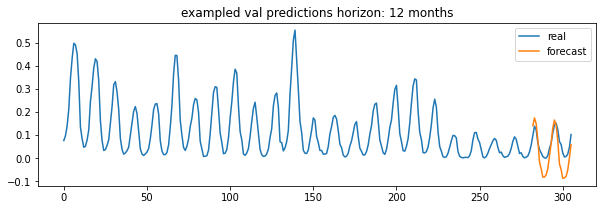

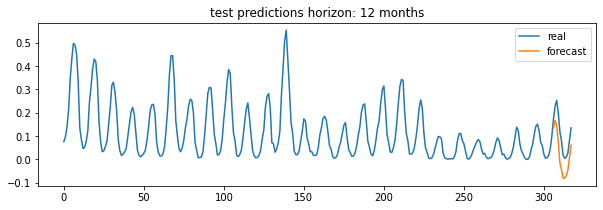

In [111]:
plot_prediction(df_train['org'].values, df_val['org'].values, forceast_val, title=VAL_PREDICTIONS_TITLE)
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, forecasts_test[model_name]['org'], title=TEST_PREDICTIONS_TITLE)

Prophets models results are far away from the desired ones. Models were tested with decomposition, box-cox transformation and on raw data. Prophet performance was the best with box-cox transformation. Neural prophet score was the highest on raw data.

<h1>N-beats </h1>

N-beats  (Neural basis expansion analysis for interpretable time series)  deep neural architecture based on backward andforward residual links and a very deep stack of fully-connected layers. 

As we have only ~300 observations it is obvious that neural network will overfit in our case, however trained with small number of epochs, used in model ensemble with small weigtht can contribute positively to models diversity.

In [112]:
%%capture

model_name = 'NBeats'
col = 'org_box_cox'
function = train_functions[model_name]
results_test[model_name] = {}
forecasts_test[model_name] = {}
forecasts_val[model_name] = {}
forecasts_dec_val[model_name] = {}

rolling_window(model_name, col)

_, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, HOR // 12 + 1)]
forceast_val = np.concatenate(forceast_val)

forecasts_val[model_name][col] = forecasts_val.get(col, {})
forecasts_val[model_name][col] = forceast_val

results_test[model_name][col] = results_test.get(col, {})
results_test[model_name][col] = evaluate(df_test[col], forecast_test)

forecasts_test[model_name][col] = forecasts_test.get(col, {})
forecasts_test[model_name][col] = forecast_test

At the first glance N-beats forecast accuracy varies. Exampled val predictions (2) look very good however on the test set model fails to predict correctly spike heigth. Run with different context length N-Beats predictions differ a lot. They are not stable and dependent on model parameters (but it's hard to determine which parameters are better). 

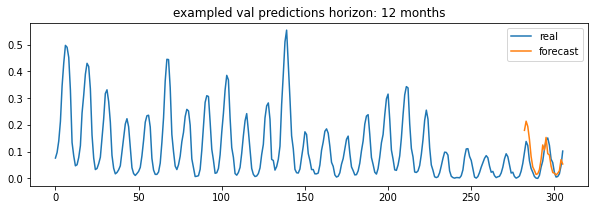

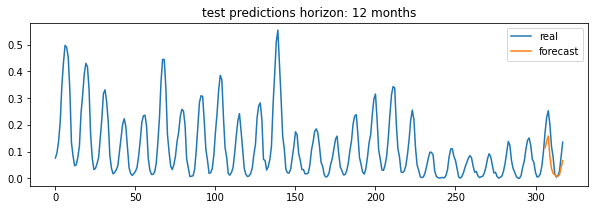

In [113]:
plot_prediction(df_train['org'].values, df_val['org'].values, inv_boxcox(forceast_val, param), title=VAL_PREDICTIONS_TITLE)
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, inv_boxcox(forecasts_test[model_name]['org_box_cox'], param), title=TEST_PREDICTIONS_TITLE)

<h1>TBATS</h1>

Key features of TBATS:
Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components

One of the main advantages of TBATS is fact that we can pass multiple seasonalities. This model is promising but due to limited time and slow performance we have not calibrated its parameters yet.

In [39]:
# %%capture

model_name = 'TBATS'
col = 'org'
function = train_functions[model_name]
results_test[model_name] = {}
forecasts_test[model_name] = {}
forecasts_val[model_name] = {}
forecasts_dec_val[model_name] = {}

rolling_window(model_name, col)

_, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, df_val.shape[0] // HOR)]
forceast_val = np.concatenate(forceast_val)

forecasts_val[model_name][col] = forecasts_val.get(col, {})
forecasts_val[model_name][col] = forceast_val

results_test[model_name][col] = results_test.get(col, {})
results_test[model_name][col] = evaluate(df_test[col], forecast_test)

forecasts_test[model_name][col] = forecasts_test.get(col, {})
forecasts_test[model_name][col] = forecast_test

TBATS results are promising (often very accurate) however there are cases where model fails spectacularly. 

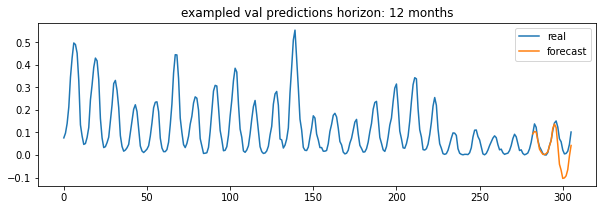

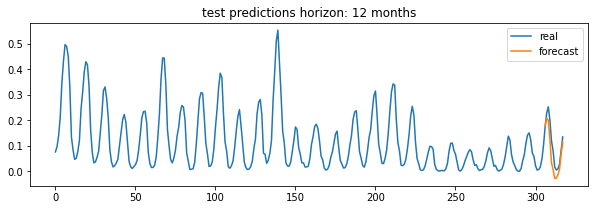

In [40]:
plot_prediction(df_train['org'].values, df_val['org'].values, forceast_val, title=VAL_PREDICTIONS_TITLE)
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, forecasts_test[model_name]['org'], title=TEST_PREDICTIONS_TITLE)

## SARIMAX
(Seasonal auto regressive integrated moving average with eXogenous factors) is it an extension of ARIMA class of models. It can handale seasonality and exogenous variables for non-stationary time series. SARIMAX is a natural choice in our case (short series, seasonal data).
Firstly Hyperparameter optimization was applied. Then model was trained on original data. At the first glance surprisingly good results were achieved on the decomposed time series (however it may be deceptive accident).

Hyperparameter optimization with hyperopt (as search space is large), we aim to minimize mae metric 

In [67]:
model_name = 'SARIMA'
col = 'org'

def objective(args):
    try:
        rolling_window(model_name, col, params=args)
    except AssertionError:
      return 10000
    return results[model_name][col]['mae']

space = {
    'trend': hp.choice('trend', ['n','c','t','ct']),
    'use_boxcox': hp.choice('use_boxcox', [True, False]),
    'p': scope.int(hp.quniform('p', 0, 4, 1)),
    'd': scope.int(hp.quniform('d', 0, 2, 1)),
    'q': scope.int(hp.quniform('q', 0, 2, 1)),
    'P': scope.int(hp.quniform('P', 0, 4, 1)),
    'D': scope.int(hp.quniform('D', 0, 0, 1)),
    'Q': scope.int(hp.quniform('Q', 0, 2, 1)),
}

# minimize the objective over the space
best = fmin(objective, space, algo=tpe.suggest, max_evals=60)

print(best)

In [47]:
model_name = 'SARIMA'
col = 'org'
function = train_functions[model_name]
results_test[model_name] = {}
forecasts_test[model_name] = {}
forecasts_val[model_name] = {}
forecasts_dec_val[model_name] = {}

rolling_window(model_name, col)

_, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, df_val.shape[0] // HOR)]
forceast_val = np.concatenate(forceast_val)

forecasts_val[model_name][col] = forecasts_val.get(col, {})
forecasts_val[model_name][col] = forceast_val

results_test[model_name][col] = results_test.get(col, {})
results_test[model_name][col] = evaluate(df_test[col], forecast_test)

forecasts_test[model_name][col] = forecasts_test.get(col, {})
forecasts_test[model_name][col] = forecast_test

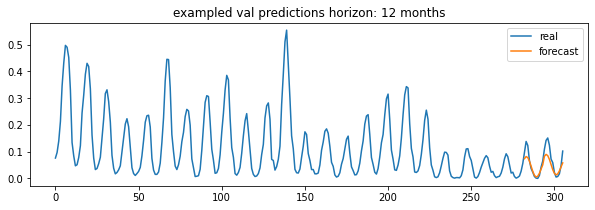

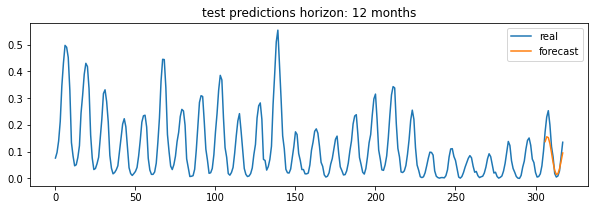

In [48]:
plot_prediction(df_train['org'].values, df_val['org'].values, forceast_val, title=VAL_PREDICTIONS_TITLE)
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, forecasts_test[model_name]['org'], title=TEST_PREDICTIONS_TITLE)

In [100]:
forecasts_dec_val[model_name] = {}

for col in ['trend', 'resid']:

  rolling_window(model_name, col)

  _, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
  forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, df_val.shape[0] // HOR)]
  forceast_val = np.concatenate(forceast_val)

  results_test[model_name][col] = results_test.get(col, {})
  results_test[model_name][col] = evaluate(df_test[col], forecast_test)

  forecasts_test[model_name][col] = forecasts_test.get(col, {})
  forecasts_test[model_name][col] = forecast_test

  forecasts_val[model_name][col] = forecasts_val.get(col, {})
  forecasts_val[model_name][col] = forceast_val

In [105]:
dec = [x[0].values + y[0].values + y[1]['season'].values for x, y in zip(forecasts_dec_val['SARIMA']['resid'], forecasts_dec_val['SARIMA']['trend'])]
dec = [evaluate(y[1]['org'], x) for x, y in zip(dec, forecasts_dec_val['SARIMA']['trend'])]

In [106]:
results['SARIMA (decomposed)'] = {}
results['SARIMA (decomposed)']['org'] = pd.DataFrame(dec).sum(axis=0).to_dict()

## Predicon on the decomposed time series

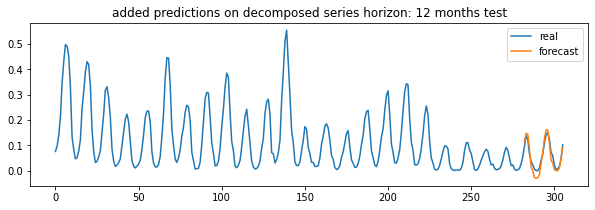

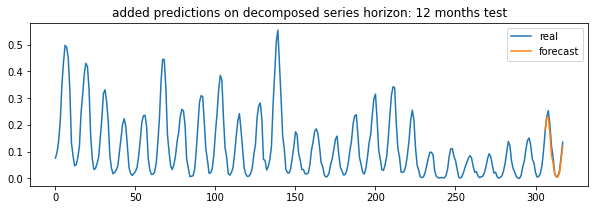

In [55]:
decomposed = forecasts_val[model_name]['trend'] + df_val['season'].values + forecasts_val[model_name]['resid']
plot_prediction(df_train['org'].values, df_val['org'].values, decomposed, title=f'{DECOMPOSED_TITLE} test')

decomposed = forecasts_test[model_name]['trend'] + df_test['season'].values + forecasts_test[model_name]['resid']
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, decomposed, title=f'{DECOMPOSED_TITLE} test')

## ETS 

Error Trend and Seasonality as name suggests models error, trend and seasonality in the data. It is categorized as exponential smoothing state space models. ETS is very simple and fast method. It handles seasonal data so it can be applied to our series without any transformation. Hyperparameter optimization (grid search is used as search space is not that large).  we want to minimize mae metric.

In [66]:
model_name = 'ETS'
col = 'org'

params = [["add", "mul", None], ['add', 'mul'], [True, False]]

search_space = list(itertools.product(*params))

function = train_functions[model_name]

params_results = []

for args in search_space:
    rolling_window(model_name, col, params={'trend': args[0], 'seasonal': args[1], 'use_boxcox': args[2]})
    params_results.append((results[model_name][col]['mae'], args))

params_results.sort()
params_results[:3]

[(23.916467228027862, ('mul', 'mul', False)),
 (23.960807524050033, ('mul', 'add', False)),
 (24.004751468213993, ('add', 'mul', False))]

In [57]:
model_name = 'ETS'
col = 'org'
function = train_functions[model_name]
results_test[model_name] = {}
forecasts_test[model_name] = {}
forecasts_val[model_name] = {}
forecasts_dec_val[model_name] = {}

rolling_window(model_name, col)

_, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, df_val.shape[0] // HOR)]
forceast_val = np.concatenate(forceast_val)

forecasts_val[model_name][col] = forecasts_val.get(col, {})
forecasts_val[model_name][col] = forceast_val

results_test[model_name][col] = results_test.get(col, {})
results_test[model_name][col] = evaluate(df_test[col], forecast_test)

forecasts_test[model_name][col] = forecasts_test.get(col, {})
forecasts_test[model_name][col] = forecast_test

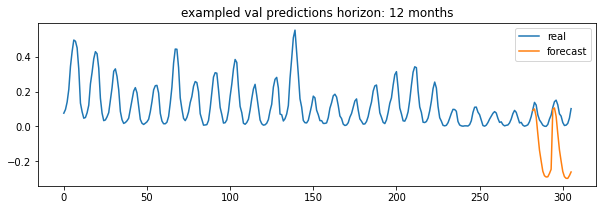

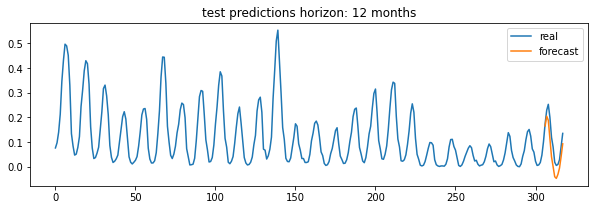

In [58]:
plot_prediction(df_train['org'].values, df_val['org'].values, forceast_val, title=VAL_PREDICTIONS_TITLE)
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, forecasts_test[model_name]['org'], title=TEST_PREDICTIONS_TITLE)

In [59]:
for col in ['trend', 'resid']:
  _, forecast_test = function(pd.concat([df_train, df_val]), df_test, col=col);
  forceast_val = [function(pd.concat([df_train, df_val]).iloc[: df_train.shape[0] + i * HOR], df_val.iloc[HOR * i:  HOR * (i + 1)], col=col)[1] for i in range(0, df_val.shape[0] // HOR)]
  forceast_val = np.concatenate(forceast_val)

  results_test[model_name][col] = results_test.get(col, {})
  results_test[model_name][col] = evaluate(df_test[col], forecast_test)

  forecasts_test[model_name][col] = forecasts_test.get(col, {})
  forecasts_test[model_name][col] = forecast_test

  forecasts_val[model_name][col] = forecasts_val.get(col, {})
  forecasts_val[model_name][col] = forceast_val

## Predicon on the decomposed time series

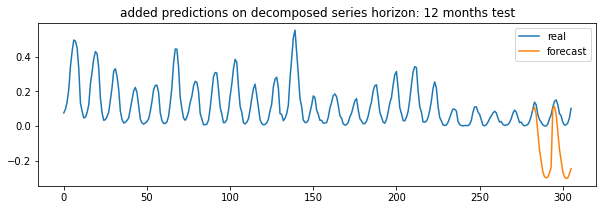

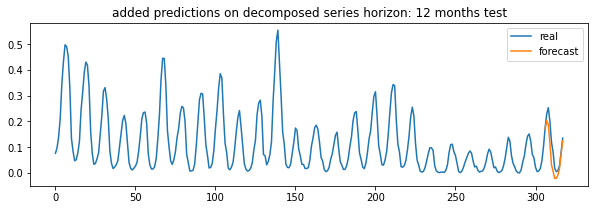

In [60]:
decomposed = forecasts_val[model_name]['trend'] + df_val['season'].values + forecasts_val[model_name]['resid']
plot_prediction(df_train['org'].values, df_val['org'].values, decomposed, title=f'{DECOMPOSED_TITLE} test')

decomposed = forecasts_test[model_name]['trend'] + df_test['season'].values + forecasts_test[model_name]['resid']
plot_prediction(pd.concat([df_train, df_val])['org'].values, df_test['org'].values, decomposed, title=f'{DECOMPOSED_TITLE} test')

## Summary: metrics calculated using the rolling window strategy on the validation set

In [107]:
val_results = {r: {'res': results[r][x] for x in results[r]} for r in results}
test_results = {r: {'res': results_test[r][x] for x in results_test[r]} for r in results_test}

In [108]:
models_scores = pd.DataFrame({r[0]: r[1]['res'] for r in val_results.items()}).T
models_scores.style.highlight_max(subset=['r2'], axis=0, color='lightgreen').highlight_min(subset=['mae', 'mape', 'mse', 'smape'], axis=0, color='lightgreen').set_precision(4)

,mae,mse,r2,mape,smape
prophet,4.7196,2.4533,5.5480,221.3697,199.0785
neural prophet,0.6381,0.0485,-6.8545,2627.4308,1279.0206
NBeats,4.0640,2.7249,6.3165,159.5252,169.5263
TBATS,0.2690,0.0110,7.7576,534.5903,559.7575
SARIMA,0.2373,0.0065,8.1130,796.1235,747.4289
ETS,24.1152,48.5004,-19081.4484,1165.5576,2243.3806
SARIMA (decomposed),0.2405,0.0068,9.3657,667.2056,737.4317


The above summary suggests that the best performing models are SARIMA and TBATS perform best. They will be used for ensembling.

## Summary: metrics calculated on the test set

 Other models will also be calculated, but only for reference. The aim is to assess the performance of the selected ensemble.

In [116]:
test_results['TBATS + NBEATS'] = {}
test_results['TBATS + NBEATS']['res'] = evaluate(df_val['org'].values, (forecasts_val['NBeats']['org_box_cox'] * 0.05 + np.expand_dims(forecasts_val['TBATS']['org'], axis=1) * 0.95))

test_results['TBATS + NBEATS + SAR(I)MA'] = {}
test_results['TBATS + NBEATS + SAR(I)MA']['res'] = evaluate(df_val['org'].values, (forecasts_val['NBeats']['org_box_cox'] * 0.05 + np.expand_dims(forecasts_val['TBATS']['org'], axis=1) * 0.3 + np.expand_dims(forecasts_val['SARIMA']['org'], axis=1) * 0.65))

test_results['TBATS + SAR(I)MA'] = {}
test_results['TBATS + SAR(I)MA']['res'] = evaluate(df_val['org'].values, np.expand_dims(forecasts_val['TBATS']['org'], axis=1) * 0.3 + np.expand_dims(forecasts_val['SARIMA']['org'], axis=1) * 0.7)

models_scores = pd.DataFrame({r[0]: r[1]['res'] for r in test_results.items()}).T
models_scores.style.highlight_max(subset=['r2'], axis=0, color='lightgreen').highlight_min(subset=['mae', 'mape', 'mse', 'smape'], axis=0, color='lightgreen').set_precision(4)

,mae,mse,r2,mape,smape
prophet,0.5837,0.3735,0.0125,35.1127,28.7741
neural prophet,0.0887,0.0086,-0.2021,168.5790,124.1938
NBeats,0.5226,0.3181,0.1591,31.9101,26.4333
TBATS,0.0388,0.0022,0.6950,66.0224,76.3842
SARIMA,0.1143,0.0161,-4.4669,191.0666,162.5436
ETS,0.1143,0.0161,-4.4669,191.0666,162.5436
TBATS + NBEATS,0.1432,0.0237,-8.6808,447.7715,168.9337
TBATS + NBEATS + SAR(I)MA,0.1279,0.0171,-6.0008,378.9825,178.6199
TBATS + SAR(I)MA,0.0247,0.0010,0.5884,45.5631,57.6077


The ensembling of TBATS and SARIMA has superior performance on the test set. Nice!

## Forecasts

Using the above ensemble, a forcast for the next 12 months is calculated and visualized below.

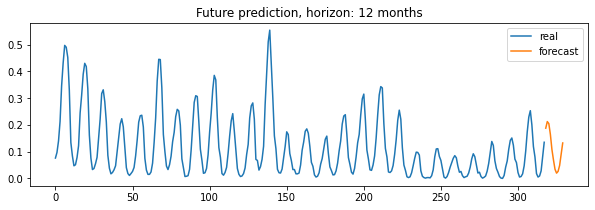

In [64]:
_, forecast_tbats = train_functions['TBATS'](pd.concat([df_train, df_val, df_test]), df_test, col=['org'])
_, forecast_sarima = train_functions['SARIMA'](pd.concat([df_train, df_val, df_test]), df_test, col=['org'], future=True)

plot_prediction(pd.concat([df_train, df_val, df_test])['org'].values, df_test['org'].values, forecast_tbats * 0.3 + forecast_sarima * 0.7, title='Future prediction, horizon: 12 months', future=True)